In [ ]:
# Determinism env (set before Torch ops for cuBLAS determinism)
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
from datasets import load_dataset

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")


# Repro + determinism

try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HookedTransformer.from_pretrained("gpt2-small").to(device).eval()


Using device: cuda


/workspace/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [36]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [46]:
PREPEND_BOS = True
prefix = "The doctor said that "

# Tokenize once for the main prefix; used by the sanity check
toks_prefix = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)

# Token IDs for the contrastive pair
he_id = int(model.to_tokens(" he", prepend_bos=False)[0, 0])
she_id = int(model.to_tokens(" she", prepend_bos=False)[0, 0])

# Injection and readout configuration
INJECT_SITE = "hook_resid_mid"
READ_SITE = "hook_resid_post"

# Alpha sweep grid
# ALPHA_RANGE = np.array(np.arange(-1, 1, 0.1), dtype=float)
ALPHA_RANGE = np.array(np.arange(-10, 10, 0.5), dtype=float)


# inject and read layers
INJECT_LAYERS = list(range(model.cfg.n_layers))
READ_LAYERS = list(range(model.cfg.n_layers))


In [38]:
# 1. Load the HuggingFace Winogender dataset and convert to a DataFrame
# has only one split labeled "test" for some reason
dataset = load_dataset("oskarvanderwal/winogender", 'all')
df = (dataset["test"].to_pandas())[["gender", "sentence", "occupation"]]

# 2. Filter down to only male and female
df = df[df["gender"].isin(["female", "male"])]

# 3. Group by occupation & pronoun, take the first row in each group then drop occupation col
df = (
    df
    .groupby(["occupation", "gender"], as_index=False)
    .first()      # picks one sample per (occupation,pronoun)
)

# 4. Extract prompt lists
# Create pairs of (female_prompt, male_prompt) for the same occupation
# can be made more efficient
female_df = df[df["gender"] == "female"].set_index("occupation")
male_df = df[df["gender"] == "male"].set_index("occupation")
prompt_pairs = [(female_df.loc[occ, "sentence"], male_df.loc[occ, "sentence"])
                for occ in female_df.index if occ in male_df.index]

print("Number of contrastive pairs: ", df.shape[0])


Number of contrastive pairs:  120


In [39]:
@torch.no_grad()
def residual_at_last_token(prompt: str, layer: int, site: str = INJECT_SITE):
    """
    Args:
        prompt: str, the prompt to tokenize 
        layer: int, the layer to inject the vector
        site: str, the site to inject the vector
    Returns:
        torch.Tensor, the residual stream at the last token
    """

    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)

    cache = {}

    def grab(activation, hook):
        cache["resid"] = activation.detach()
        return activation

    _ = model.run_with_hooks(toks, return_type=None, stop_at_layer=layer +
                             1, fwd_hooks=[(f"blocks.{layer}.{site}", grab)])

    # get the residual stream of the last token
    return cache["resid"][0, toks.shape[1] - 1, :].clone().to(device)


In [40]:
def build_vectors(inj: int, prompt_pairs: list[tuple[str, str]]) -> dict[str, torch.Tensor]:
    def unit(x): return x / (x.norm() + 1e-8)  # normalize vectors

    # Build the bias vector using contrastive approach
    v_sum = torch.zeros(model.cfg.d_model, device=device)
    for p in prompt_pairs:
        r_stereo = residual_at_last_token(p[0], inj)
        r_anti = residual_at_last_token(p[1], inj)
        v_sum += r_stereo - r_anti

    v_bias = unit(v_sum / len(prompt_pairs))  # bias vector
    v_rand = unit(torch.randn_like(v_bias))  # random vector
    v_orth = v_rand - (v_rand @ v_bias) / \
        (v_bias @ v_bias) * v_bias  # orthogonalize
    v_orth = unit(v_orth)  # normalize
    return {"bias": v_bias, "random": v_rand, "orth": v_orth}


In [41]:
@torch.no_grad()
def delta_logit_lens(prompt: str, steer_vec: torch.Tensor, alpha: float, inject_hook_name: str, read_hook_name: str, inject_layer: int, read_layer: int) -> float:
    """Return Δ_logit = logit(stereo) − logit(anti) at the pronoun position under a clean logit lens.
    Does not change model weights; only adds a steer_vec at the configured injection site during the forward pass.
    """
    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)
    target_pos = toks.shape[1] - 1
    cache = {}

    def steer(act, hook):
        vec = steer_vec.to(act.device)
        act[:, target_pos, :] = act[:, target_pos, :] + alpha * vec
        return act

    def readh(act, hook):
        cache["resid"] = act.detach().clone()
        return act

    _ = model.run_with_hooks(
        toks, return_type=None,
        stop_at_layer=max(inject_layer, read_layer) + 1,
        fwd_hooks=[(inject_hook_name, steer), (read_hook_name, readh)]
    )

    resid = model.ln_final(cache["resid"][:, target_pos: target_pos + 1, :])
    logits = model.unembed(resid)[0, 0, :]
    return float((logits[he_id] - logits[she_id]).item())


In [42]:
# Run single (read and inject) sweep across alpha grid
@torch.no_grad()
def run_sweep_with_hooks(vectors: dict, alpha_grid: list[float], prompt: str, inj_layer: int, read_layer: int) -> tuple[dict, str, str]:
    inject_hook_name = f"blocks.{inj_layer}.{INJECT_SITE}"
    read_hook_name = f"blocks.{read_layer}.{READ_SITE}"

    out = {k: [] for k in vectors}

    for alpha in alpha_grid:
        for name, vec in vectors.items():
            out[name].append(delta_logit_lens(
                prompt, vec, alpha, inject_hook_name, read_hook_name, inj_layer, read_layer))
    return out, inject_hook_name, read_hook_name


In [43]:
# Helper plotting and saving
def plot_and_save(results, inj, read):
    """
    Plot and save the results for a given injection and readout layer.
    Args:
        results (dict): Dictionary containing results for each vector type.
            - 'bias': list of floats representing results from applying the bias vector
            - 'random': list of floats representing results from applying the random vector  
            - 'orth': list of floats representing results from applying the orthogonal vector
    in: inj: int, injection layer
    in: read: int, readout layer
    """
    colors = {"bias": "#0072B2", "random": "#D55E00", "orth": "#009E73"}
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    for name in ["bias", "random", "orth"]:
        ax.plot(ALPHA_RANGE, results[name], label=name, color=colors[name],
                linewidth=2.5 if name == "bias" else 2, marker="o", markersize=3)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel(r"Steering coefficient $\alpha$", fontsize=14)
    ax.set_ylabel(
        r"$\Delta_{\mathrm{logit}} = \mathrm{logit}(\text{He}) - \mathrm{logit}(\text{She})$", fontsize=14)
    ax.set_title(
        f"BRC | inject: L{inj}:{INJECT_SITE} → read: L{read}:{READ_SITE}", fontsize=15, weight="bold")
    ax.legend(frameon=True, fontsize=11)
    ax.tick_params(axis="both", which="major", labelsize=12)
    note = f"BOS={PREPEND_BOS}, prefix='{prefix}'"
    ax.text(0.01, -0.14, note, transform=ax.transAxes,
            fontsize=10, color="gray")

    # Zoom in y-axis based on bias and orth
    yvals = np.array(results["bias"] + results["orth"])
    ymin = min(min(results["bias"]), min(results["orth"]))
    ymax = max(max(results["bias"]), max(results["orth"]))
    yrange = ymax - ymin
    ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
    plt.tight_layout()

    # Save to graphs/injL{inj}/brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png
    out_dir = os.path.join("graphs", f"injL{inj}")
    os.makedirs(out_dir, exist_ok=True)
    fig_path = os.path.join(
        out_dir, f"brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fig_path)


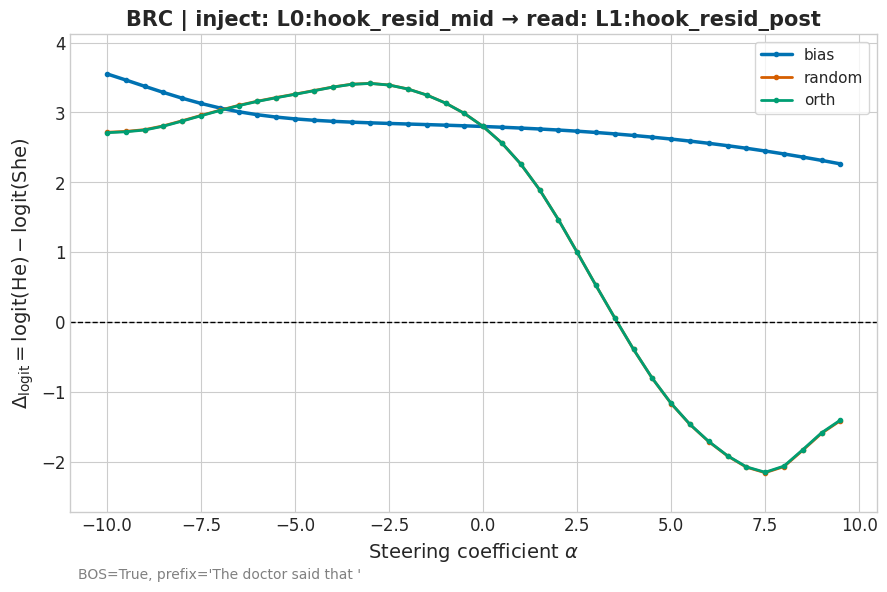

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL1_hook_resid_post.png


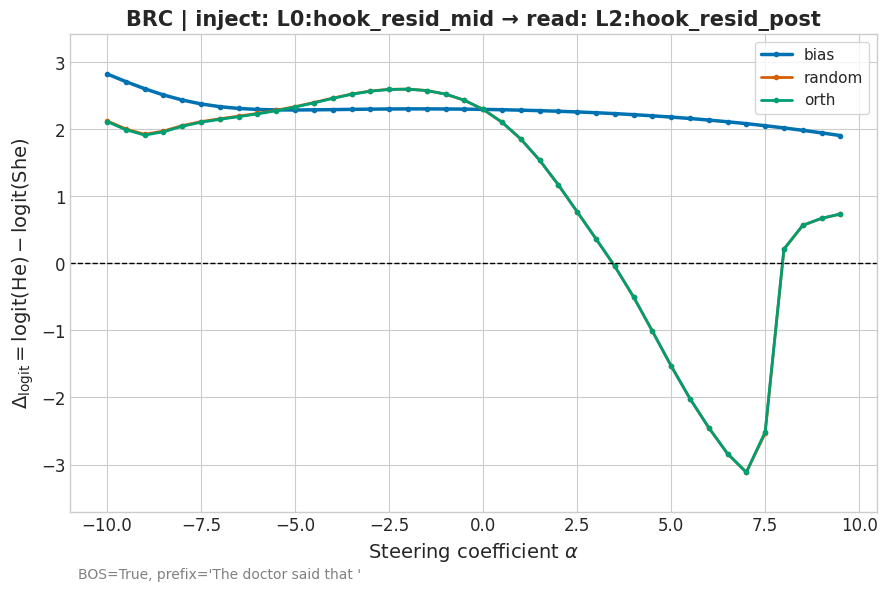

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL2_hook_resid_post.png


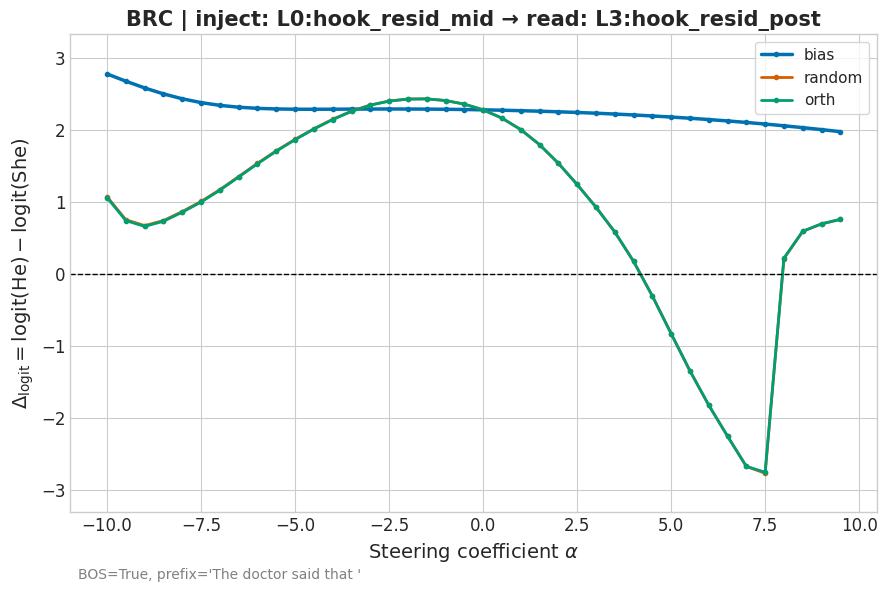

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL3_hook_resid_post.png


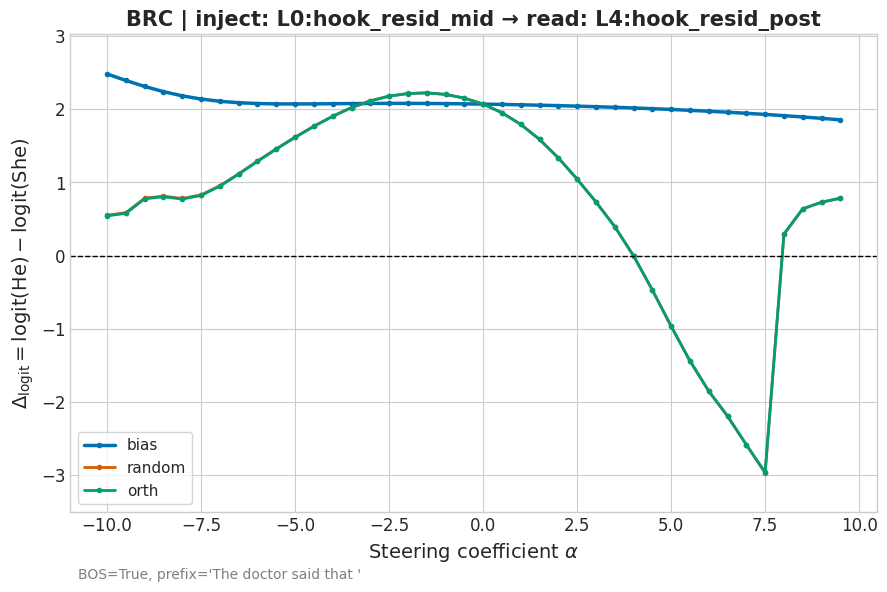

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL4_hook_resid_post.png


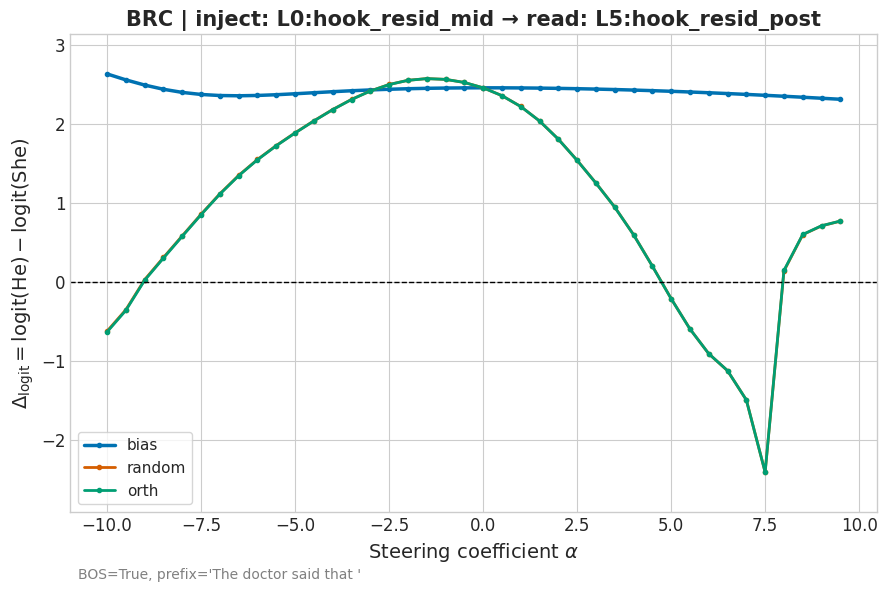

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL5_hook_resid_post.png


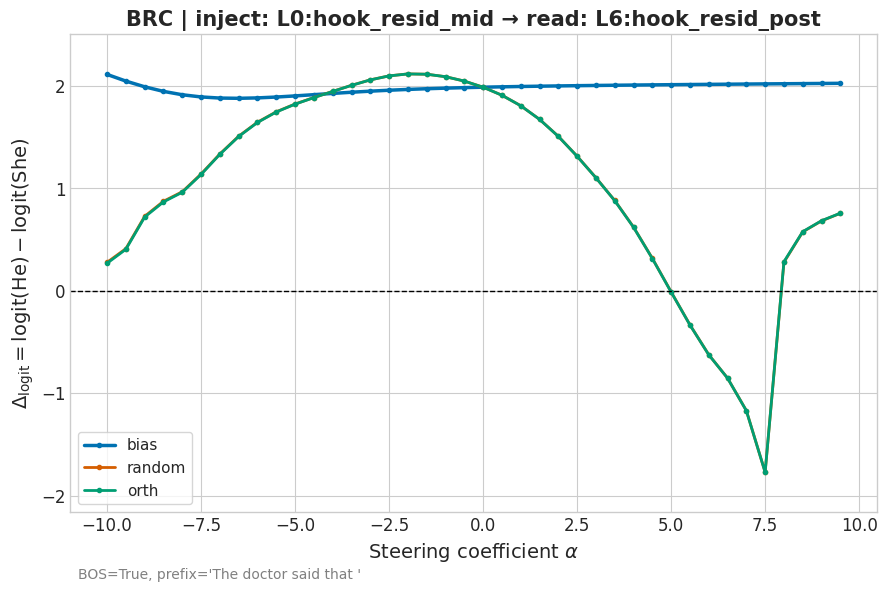

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL6_hook_resid_post.png


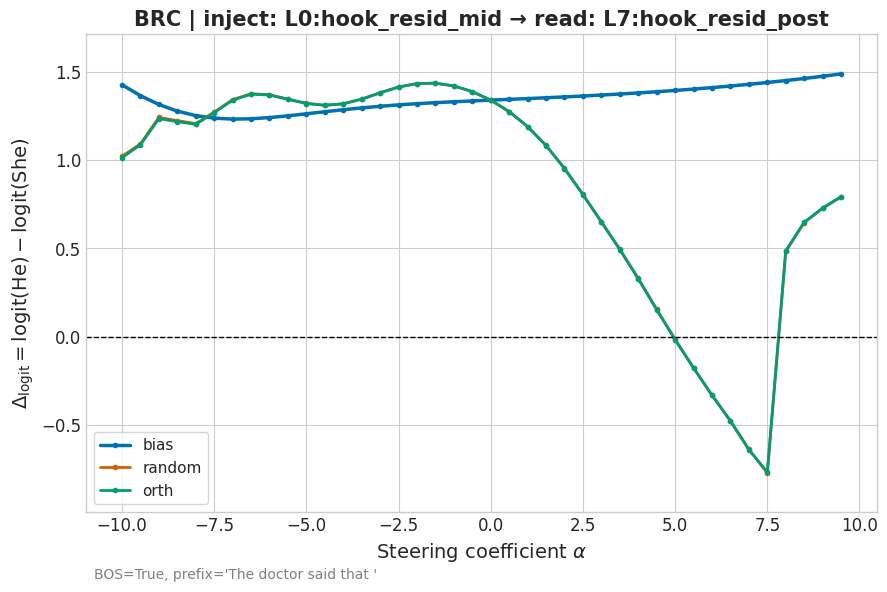

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL7_hook_resid_post.png


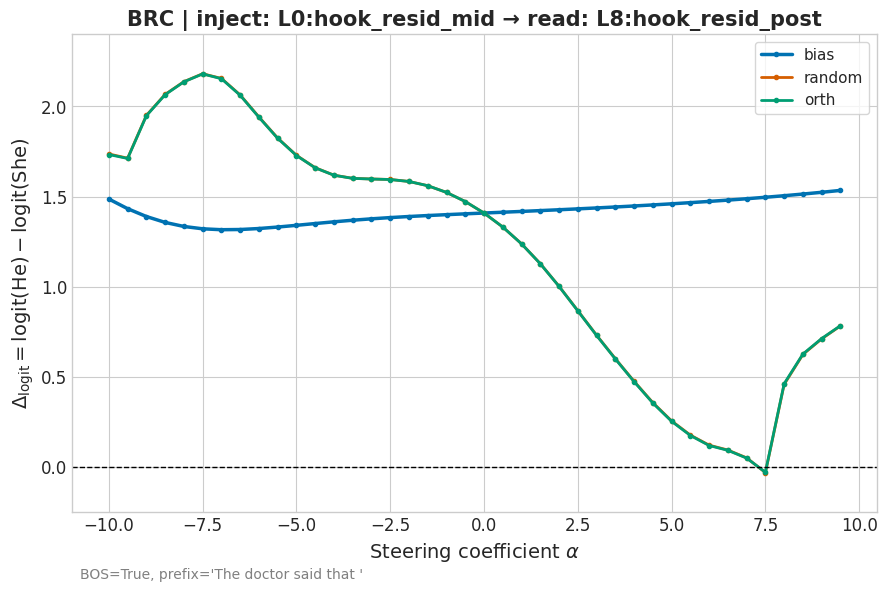

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL8_hook_resid_post.png


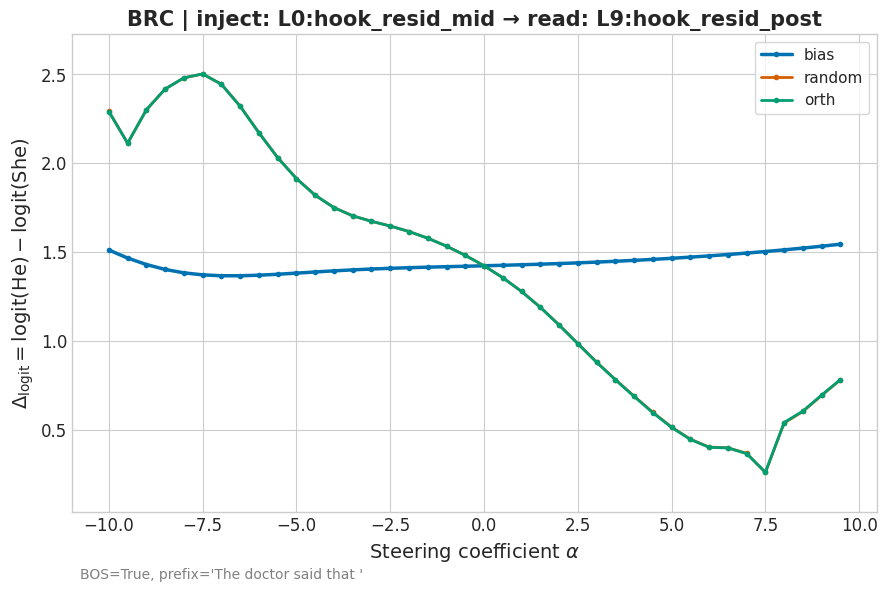

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL9_hook_resid_post.png


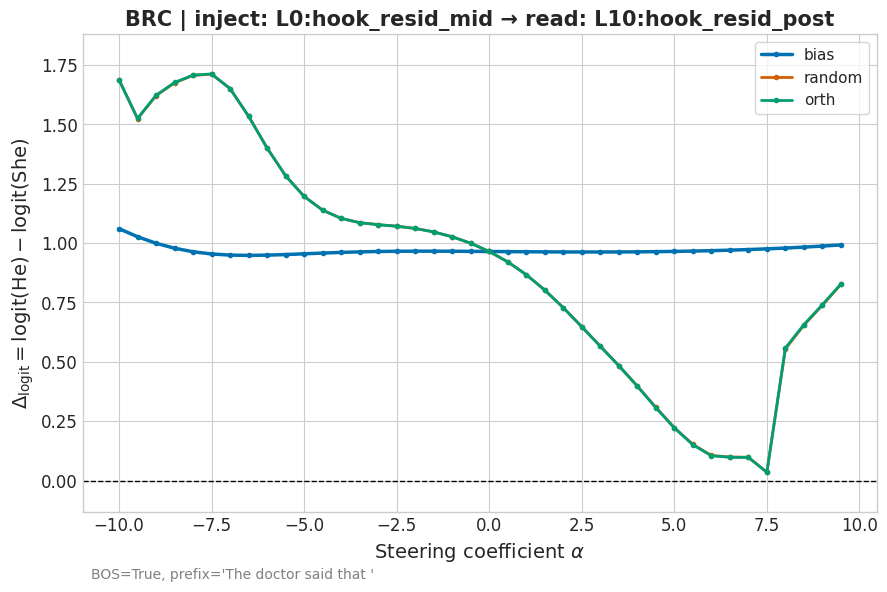

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL10_hook_resid_post.png


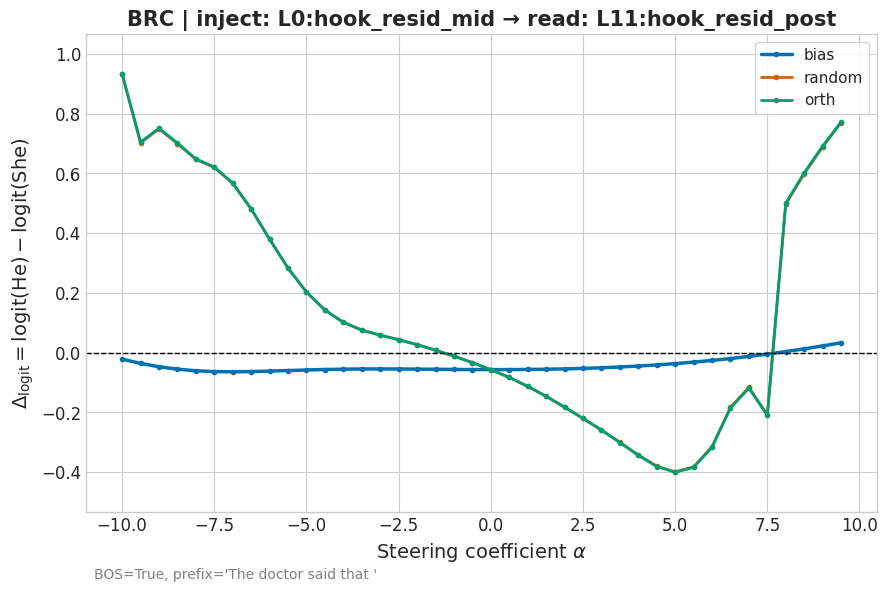

Saved: graphs/injL0/brc_injL0_hook_resid_mid_readL11_hook_resid_post.png


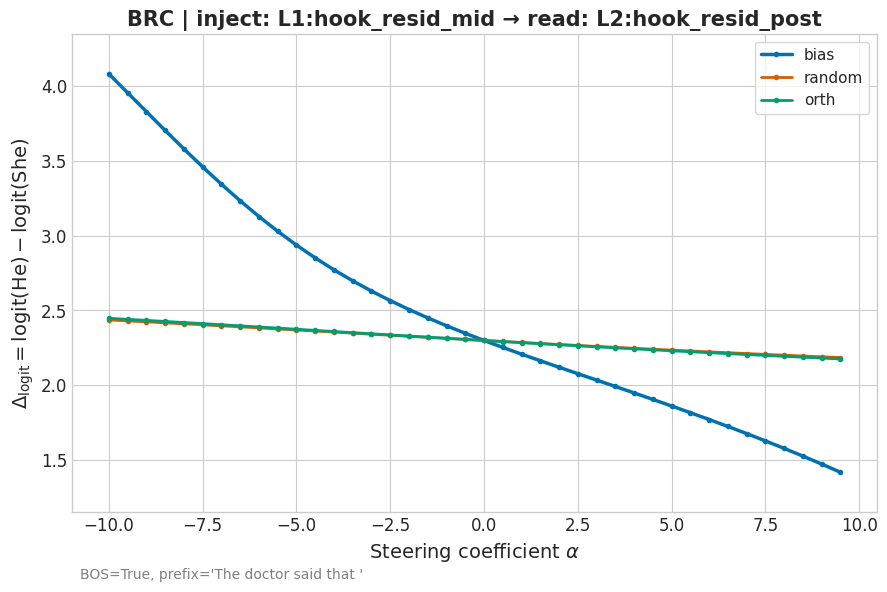

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL2_hook_resid_post.png


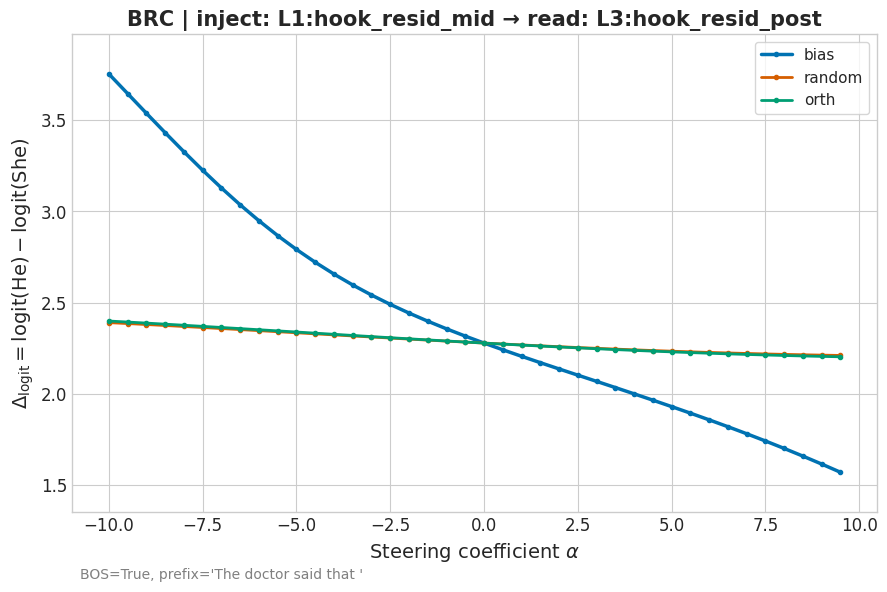

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL3_hook_resid_post.png


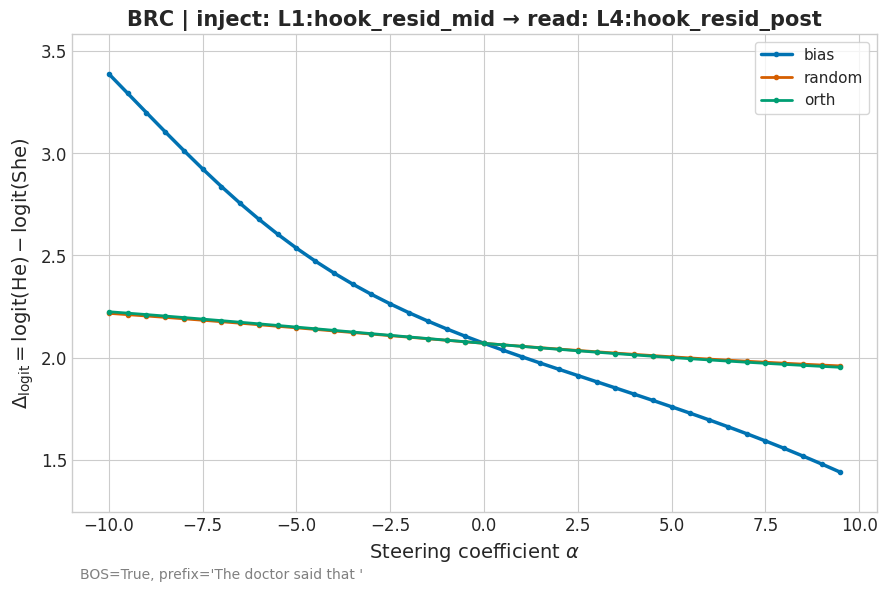

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL4_hook_resid_post.png


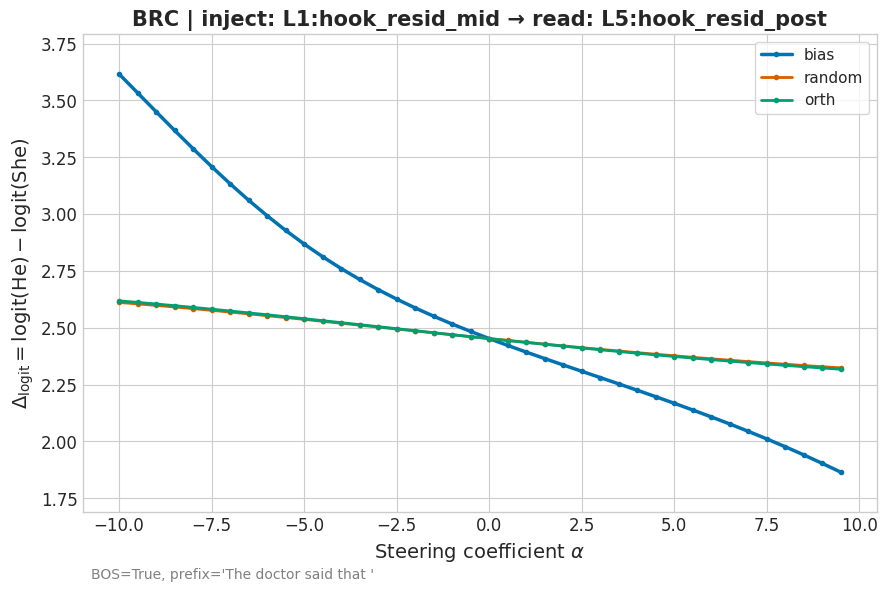

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL5_hook_resid_post.png


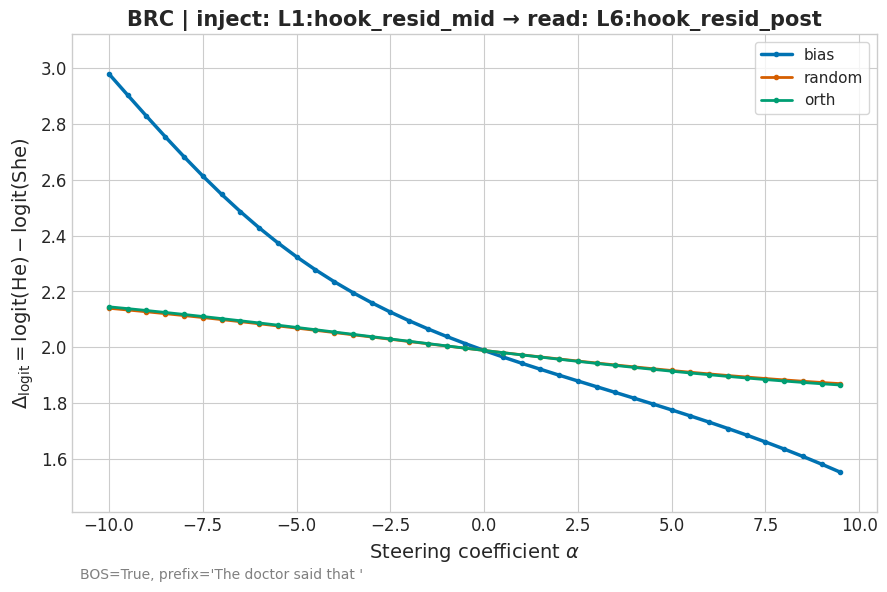

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL6_hook_resid_post.png


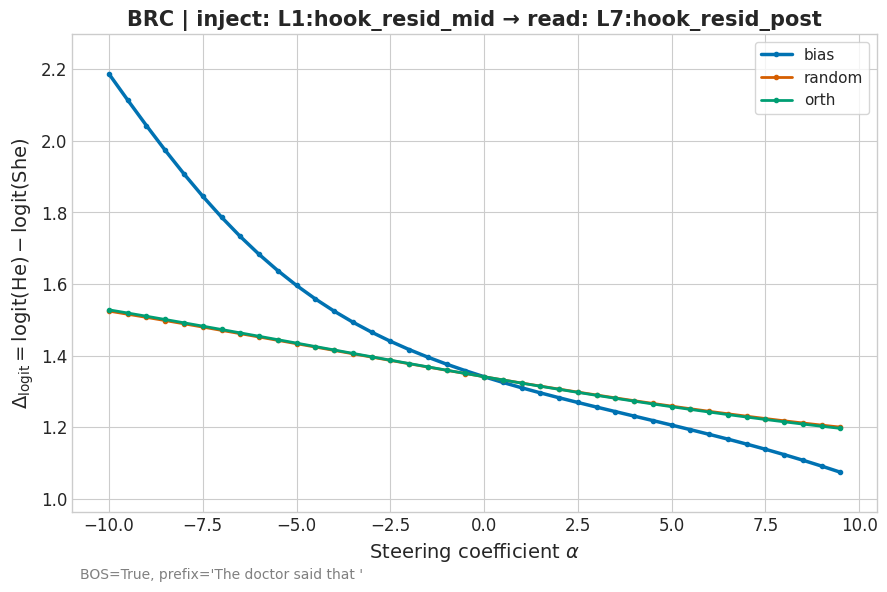

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL7_hook_resid_post.png


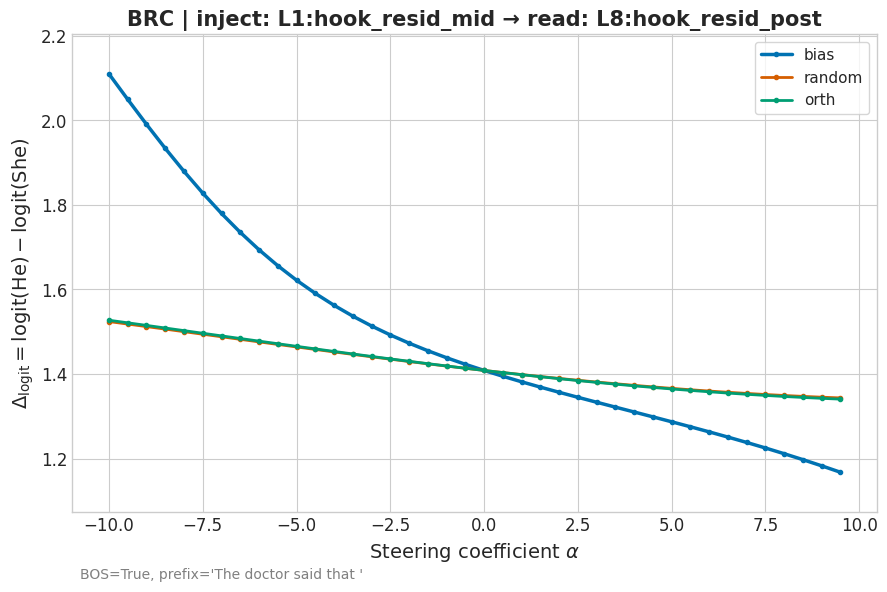

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL8_hook_resid_post.png


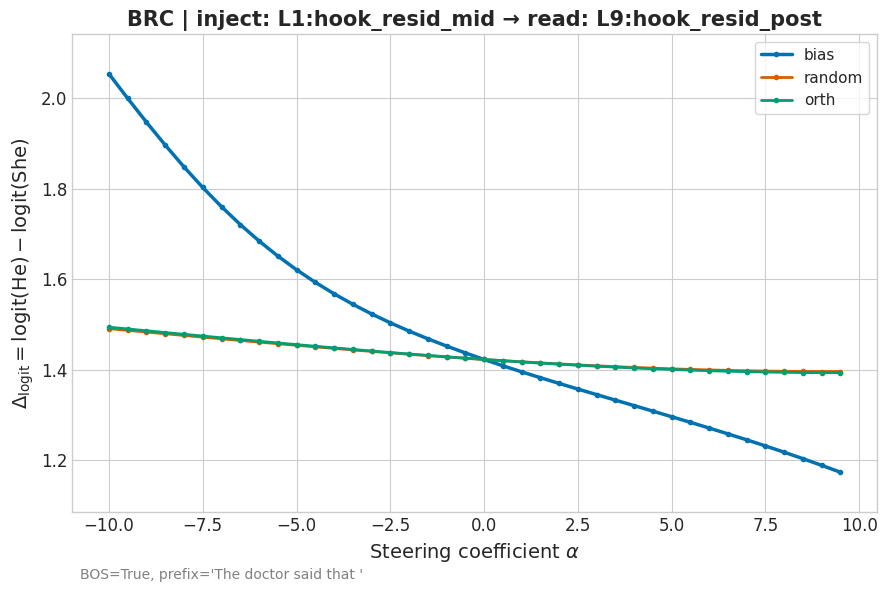

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL9_hook_resid_post.png


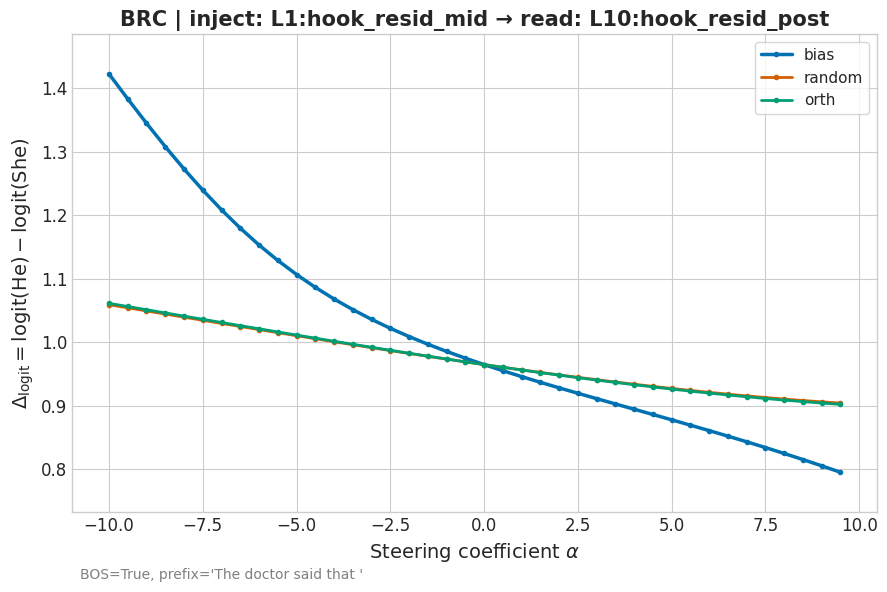

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL10_hook_resid_post.png


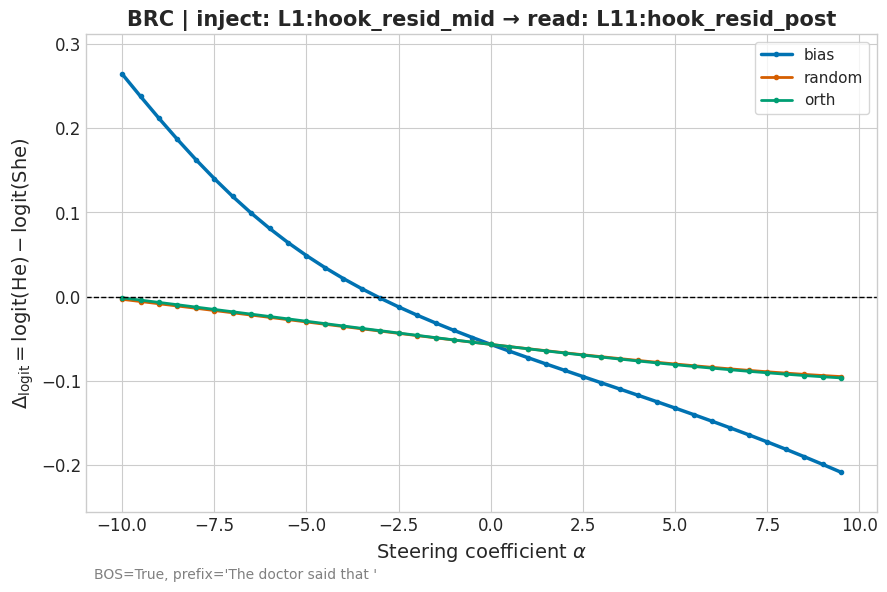

Saved: graphs/injL1/brc_injL1_hook_resid_mid_readL11_hook_resid_post.png


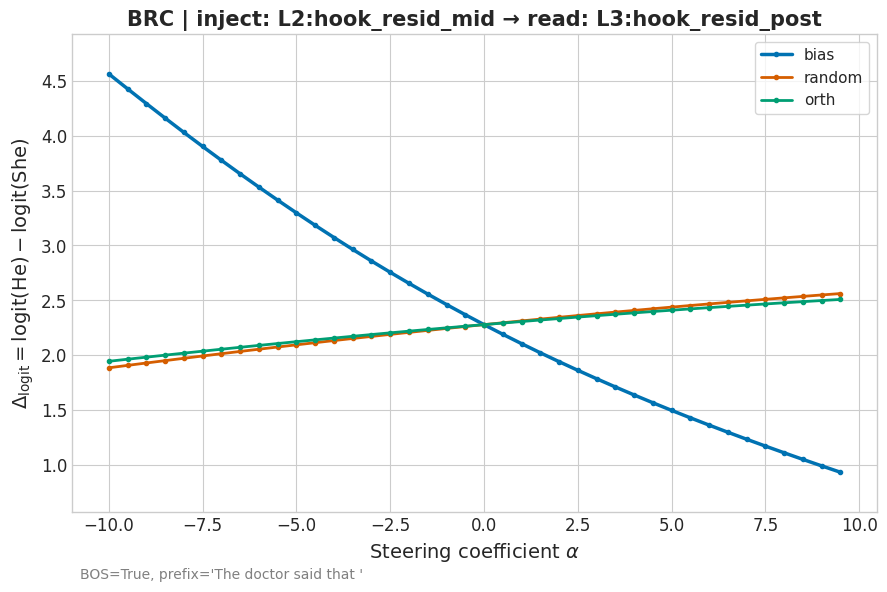

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL3_hook_resid_post.png


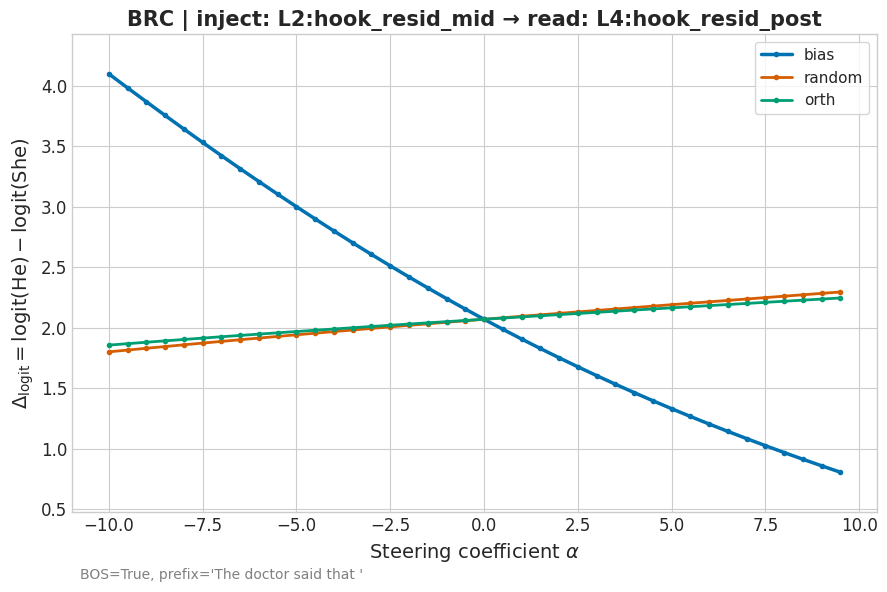

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL4_hook_resid_post.png


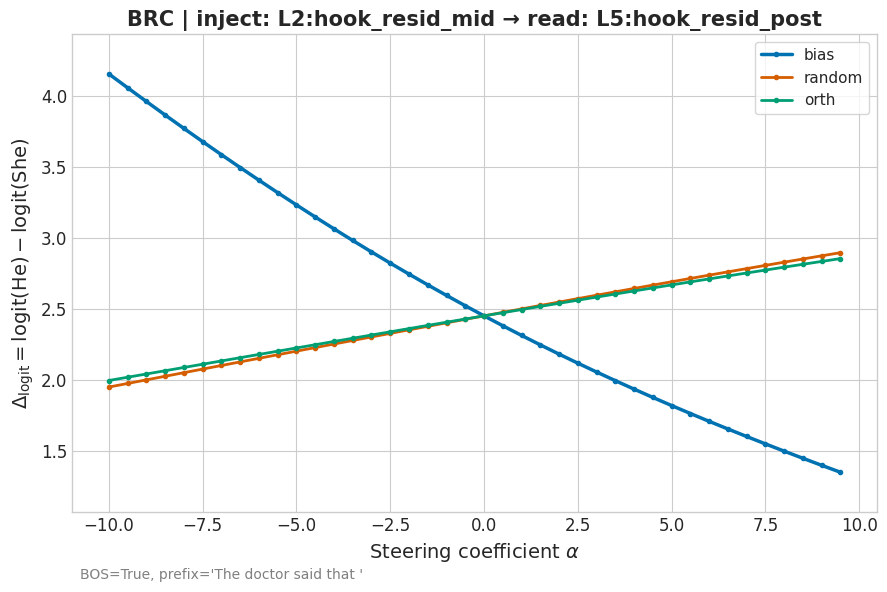

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL5_hook_resid_post.png


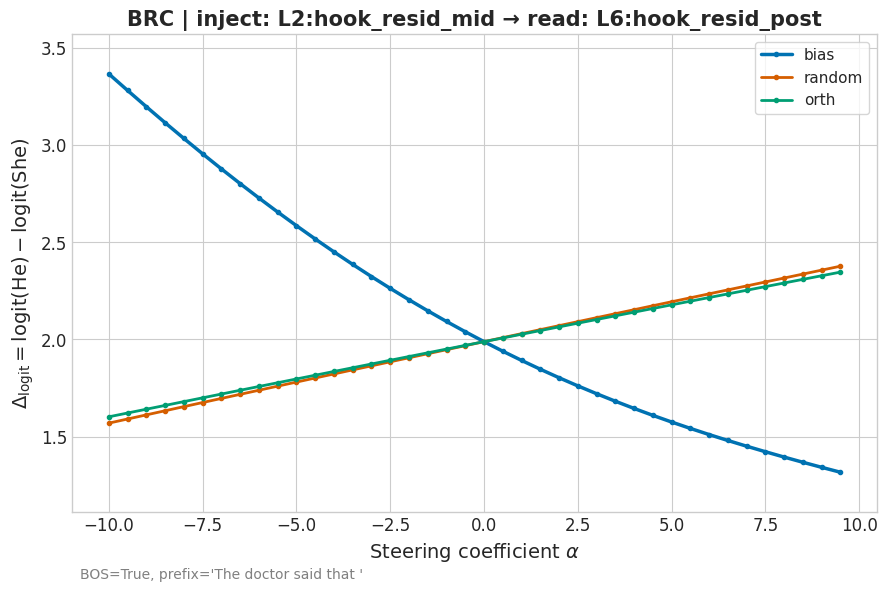

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL6_hook_resid_post.png


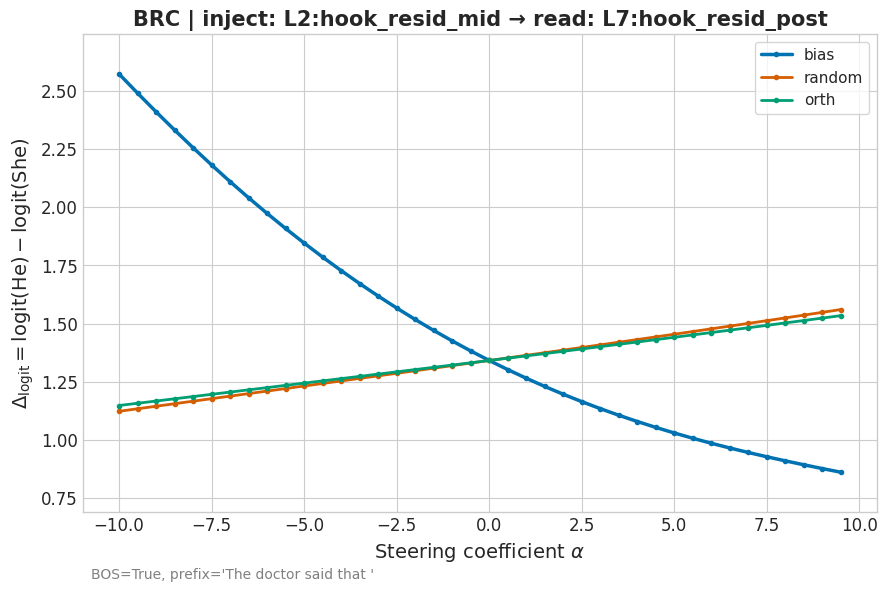

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL7_hook_resid_post.png


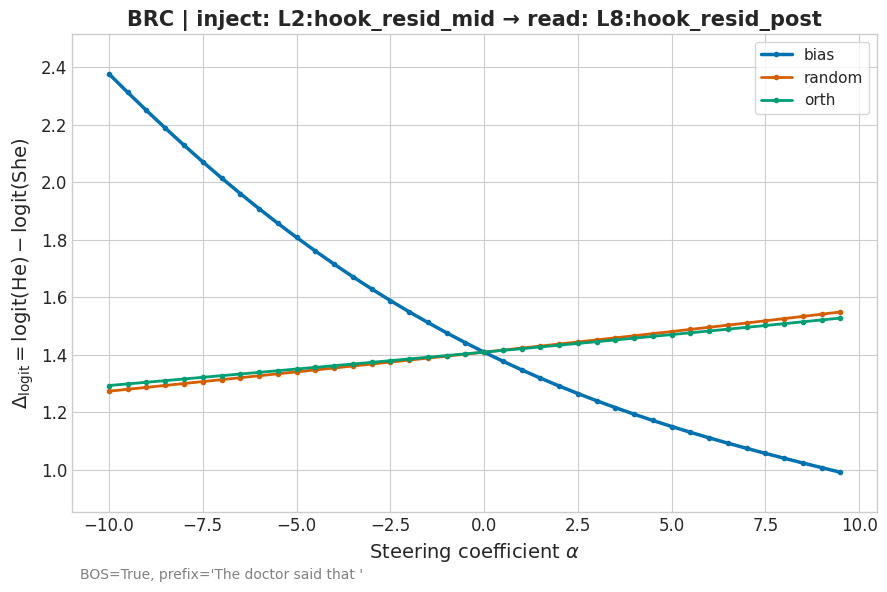

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL8_hook_resid_post.png


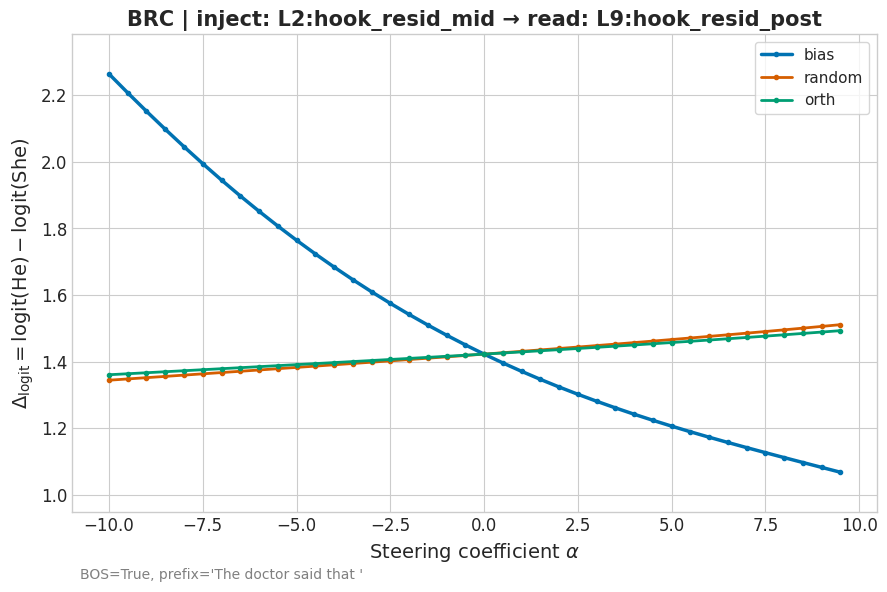

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL9_hook_resid_post.png


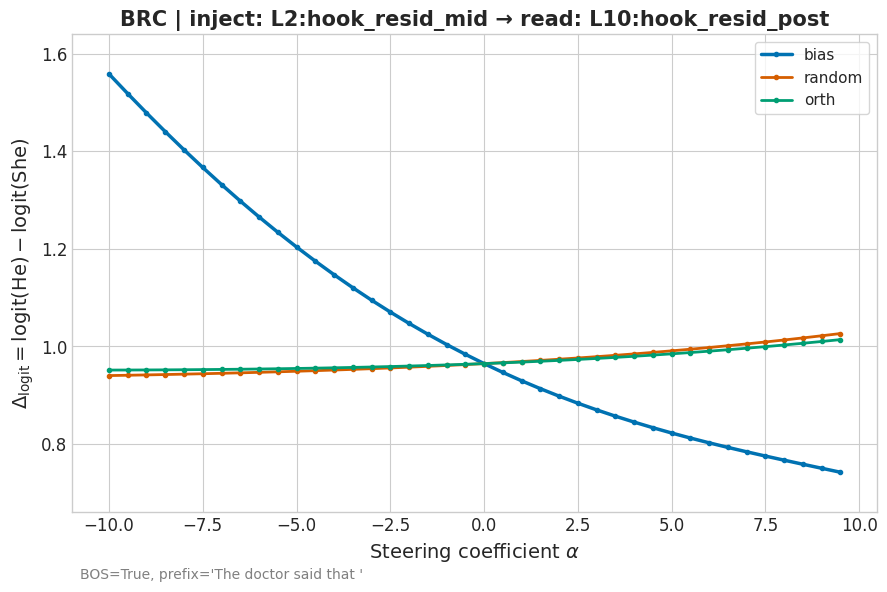

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL10_hook_resid_post.png


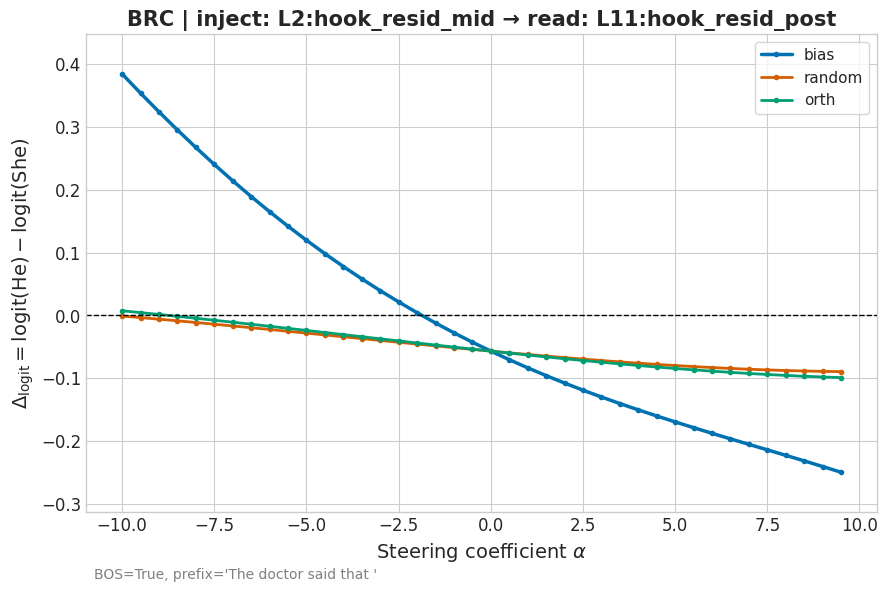

Saved: graphs/injL2/brc_injL2_hook_resid_mid_readL11_hook_resid_post.png


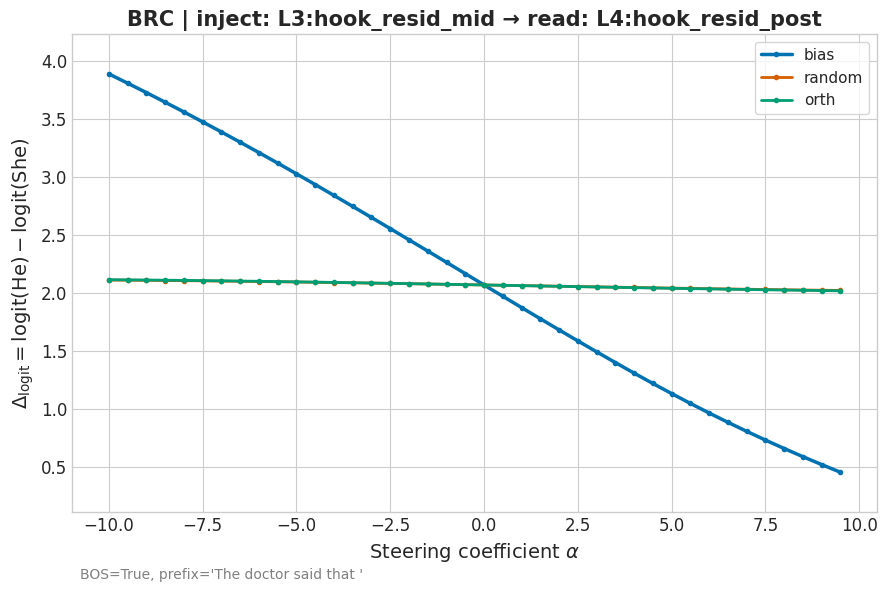

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL4_hook_resid_post.png


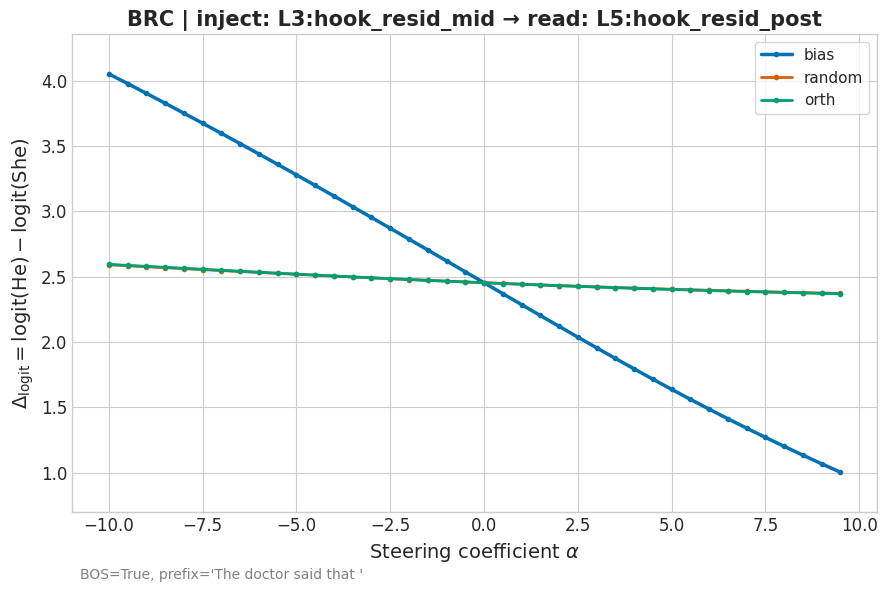

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL5_hook_resid_post.png


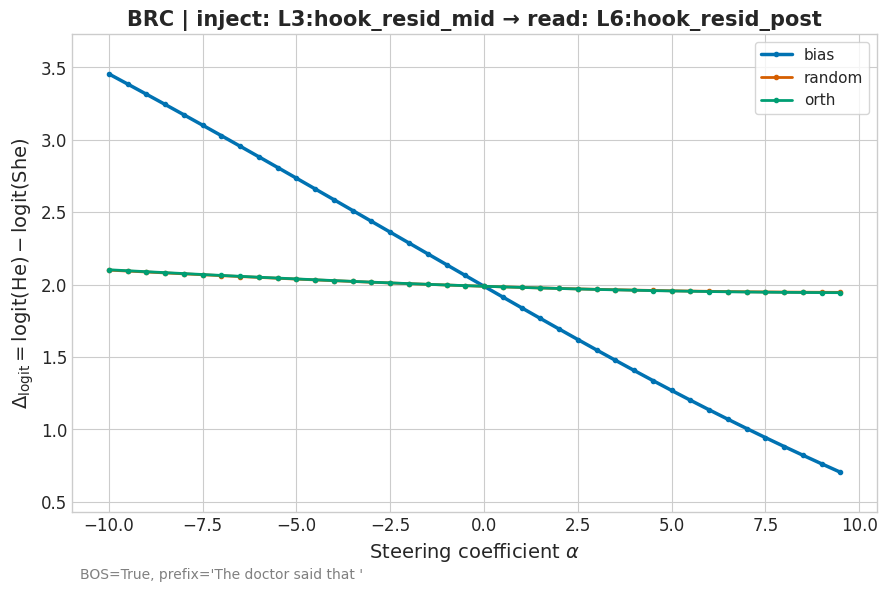

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL6_hook_resid_post.png


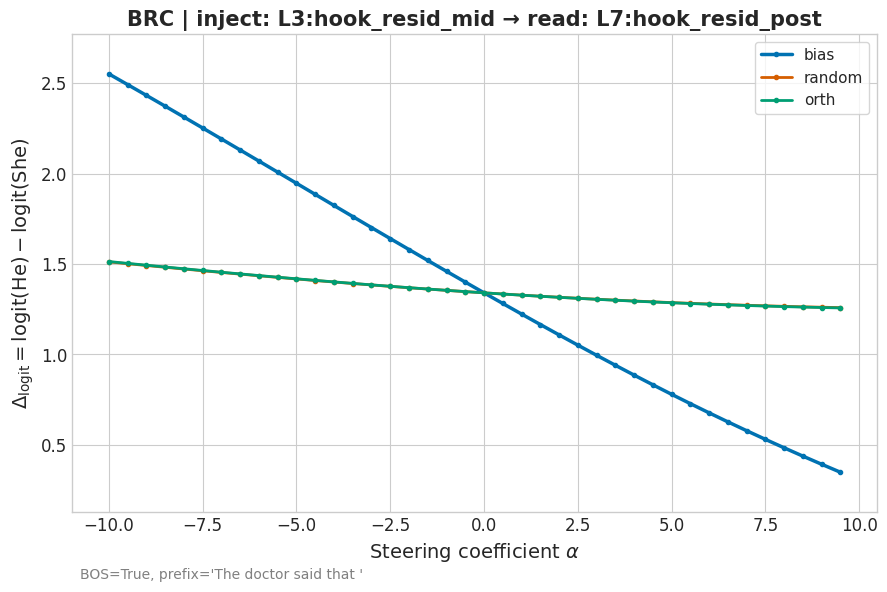

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL7_hook_resid_post.png


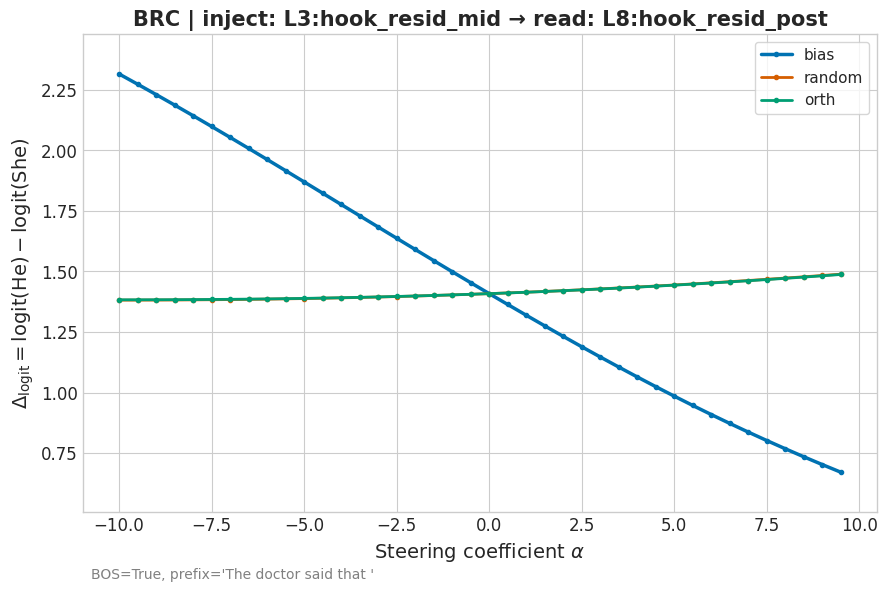

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL8_hook_resid_post.png


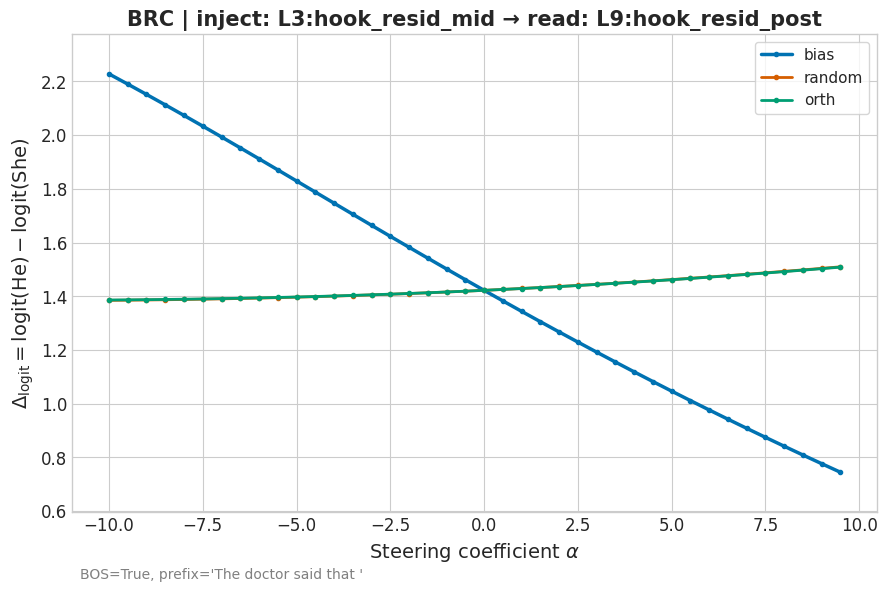

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL9_hook_resid_post.png


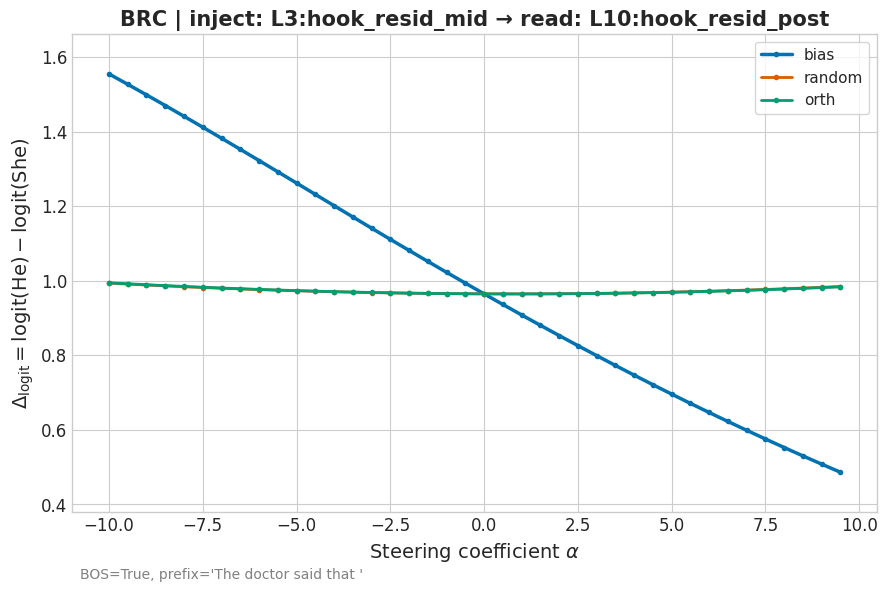

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL10_hook_resid_post.png


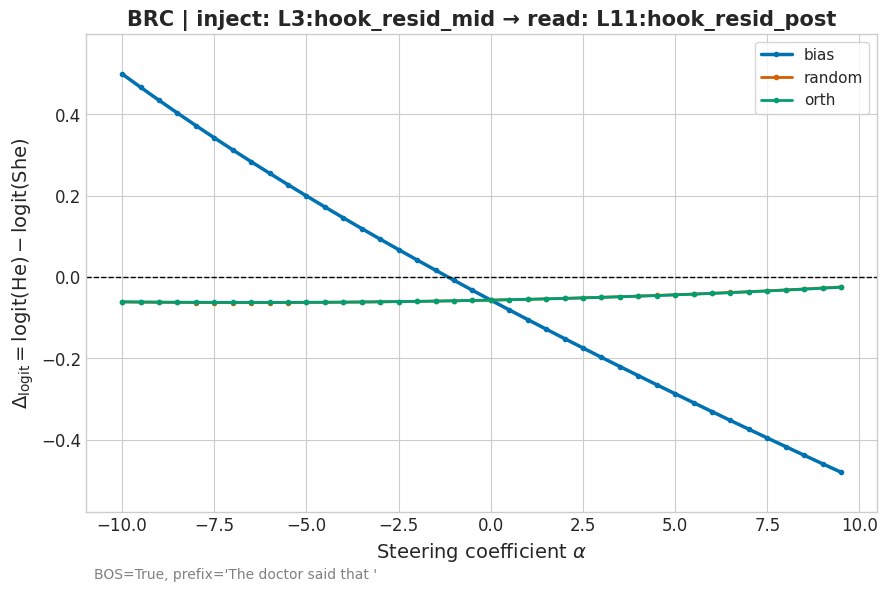

Saved: graphs/injL3/brc_injL3_hook_resid_mid_readL11_hook_resid_post.png


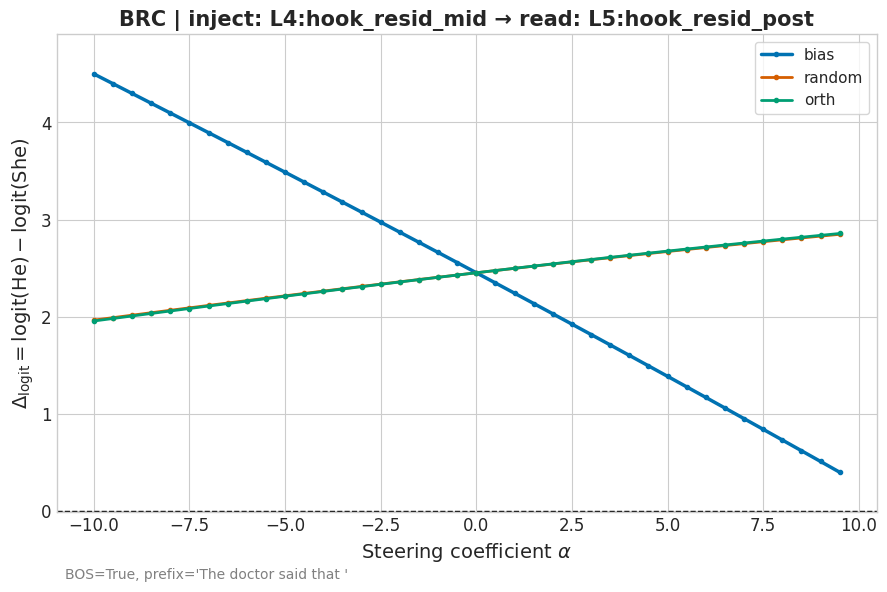

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL5_hook_resid_post.png


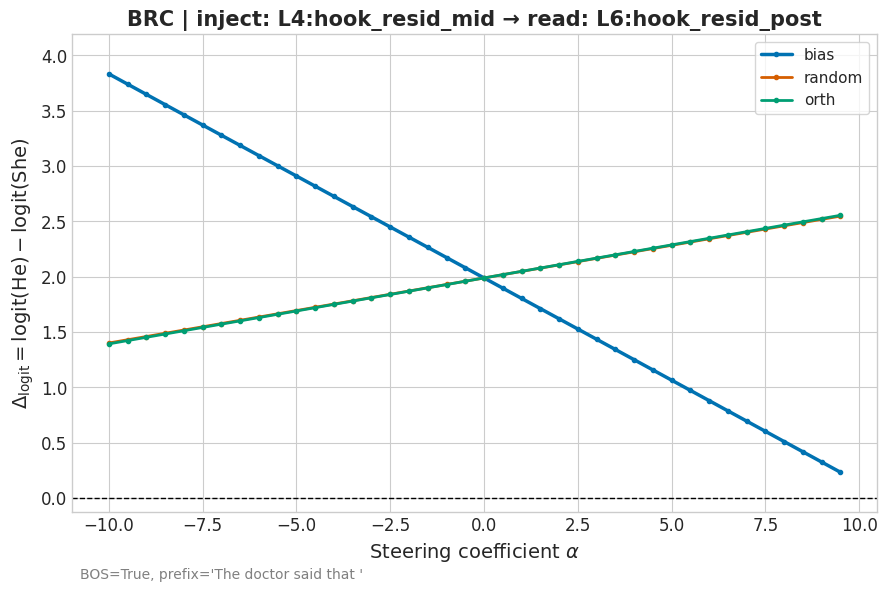

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL6_hook_resid_post.png


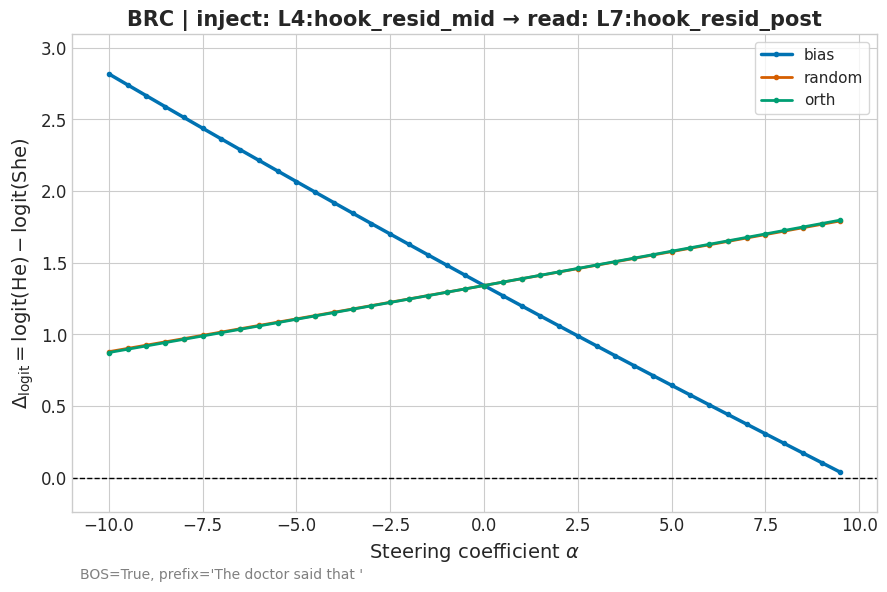

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL7_hook_resid_post.png


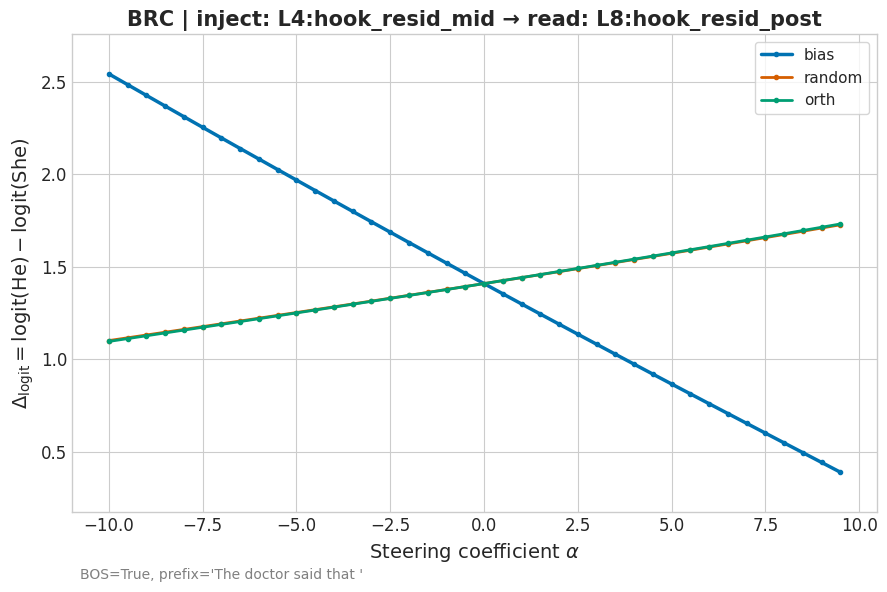

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL8_hook_resid_post.png


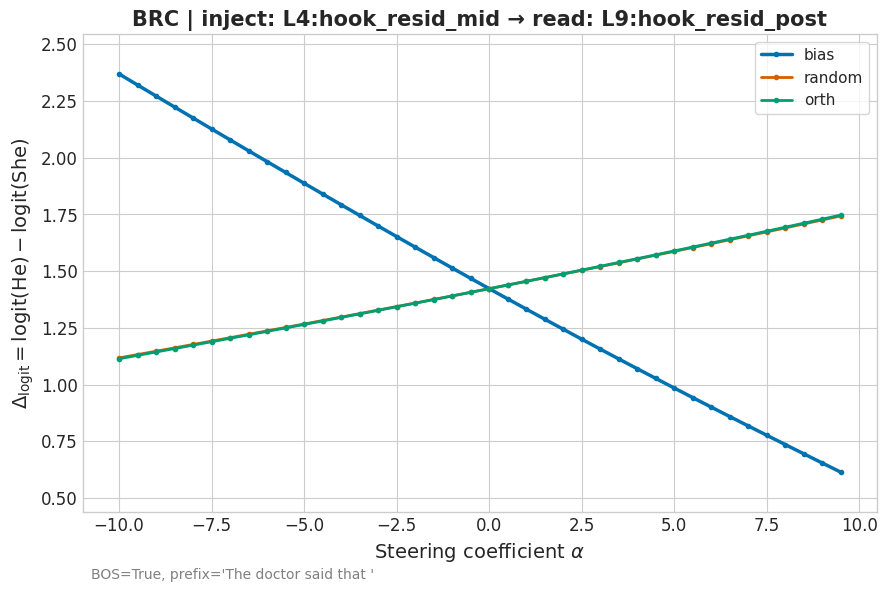

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL9_hook_resid_post.png


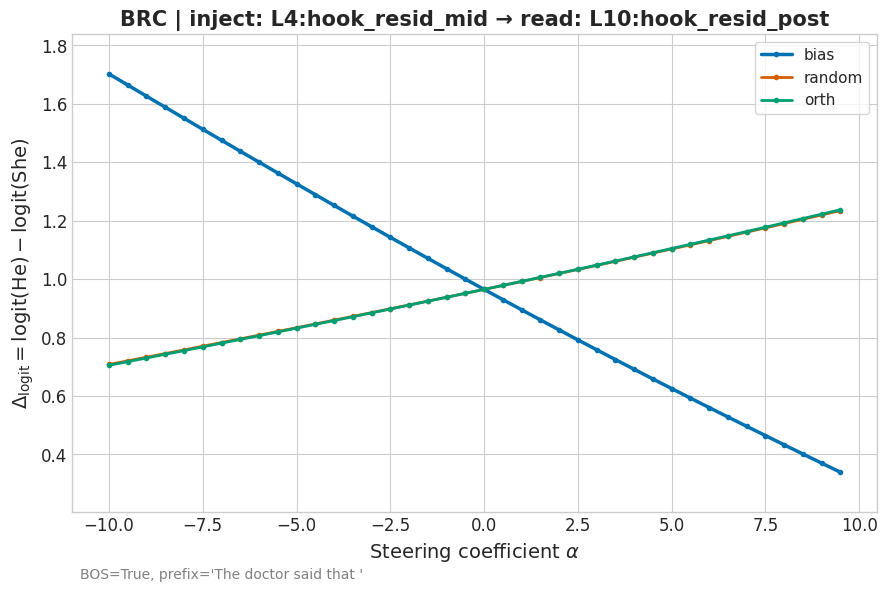

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL10_hook_resid_post.png


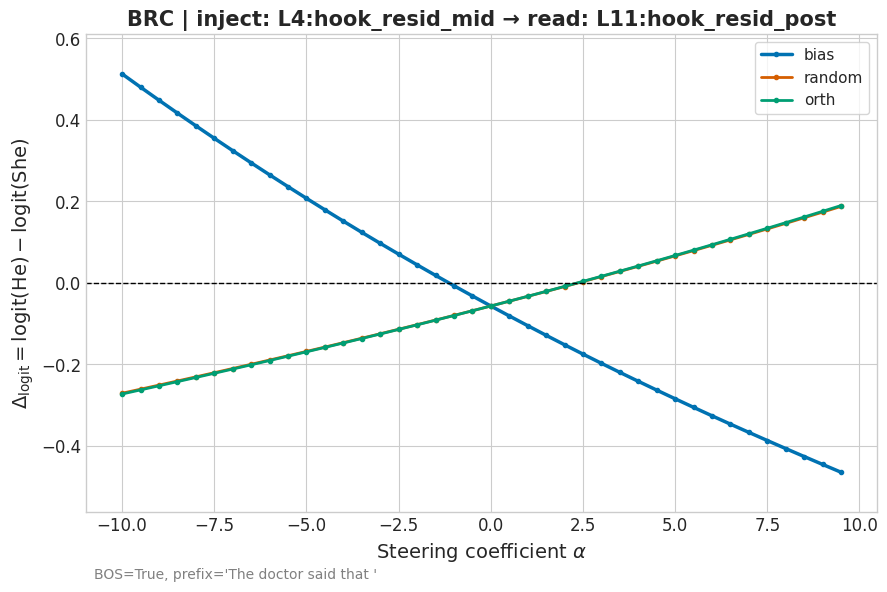

Saved: graphs/injL4/brc_injL4_hook_resid_mid_readL11_hook_resid_post.png


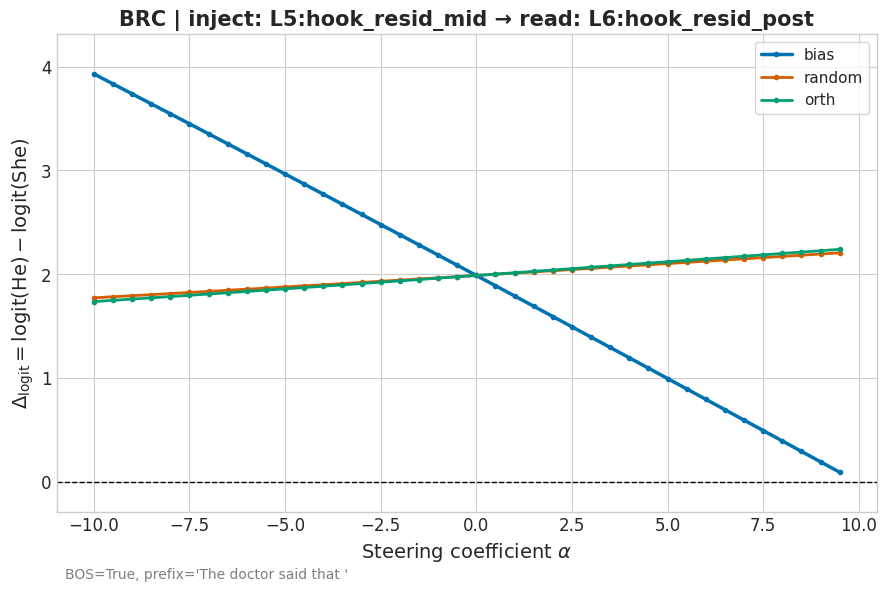

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL6_hook_resid_post.png


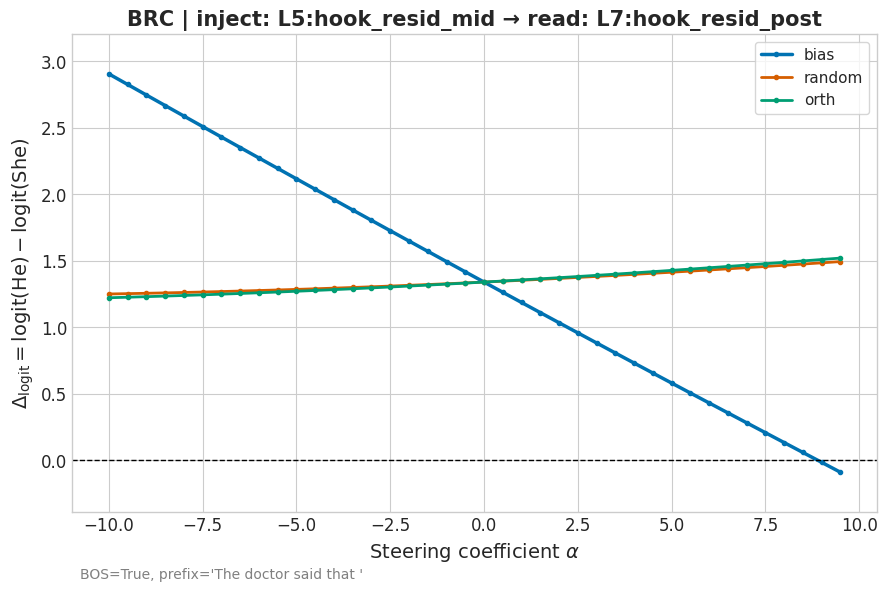

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL7_hook_resid_post.png


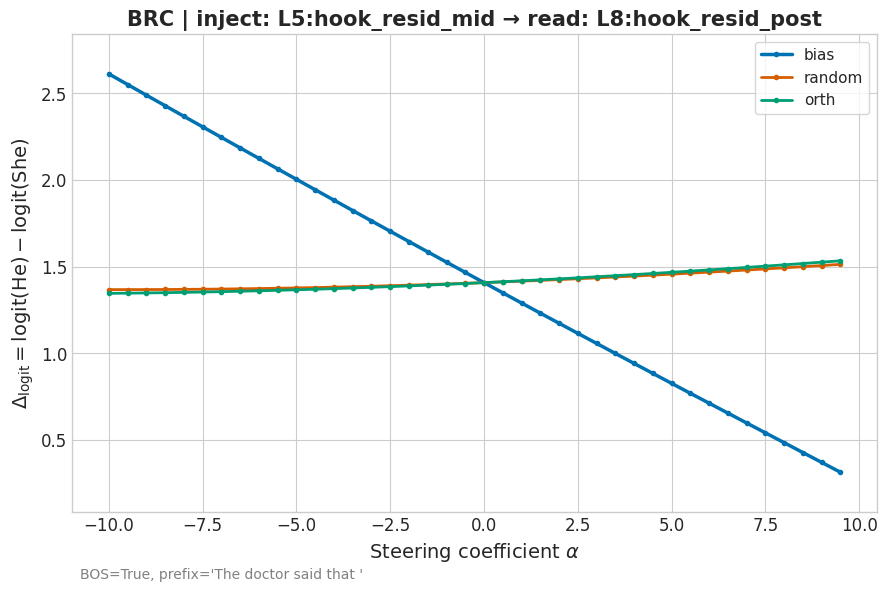

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL8_hook_resid_post.png


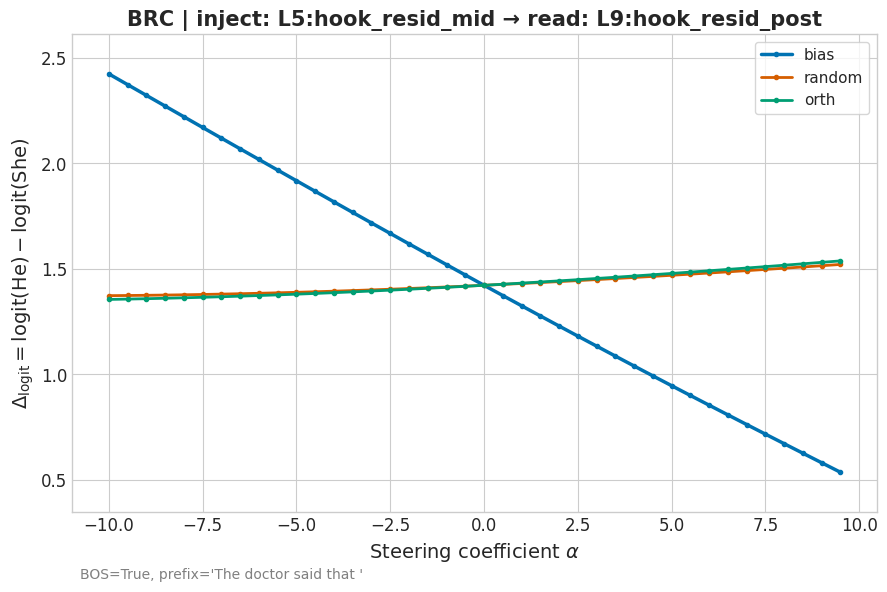

Saved: graphs/injL5/brc_injL5_hook_resid_mid_readL9_hook_resid_post.png


In [ ]:
# --- Main loop ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
for inj in [0]:
    # vectors for this injection layer
    vectors = build_vectors(inj, prompt_pairs)
    for read in READ_LAYERS:
        if read <= inj:
            continue  # skip reading before injecting

        results, inject_hook, read_hook = run_sweep_with_hooks(
            vectors, ALPHA_RANGE, prefix, inj, read)
        plot_and_save(results, inj, read)
